In [240]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import kagglehub

In [241]:
np.random.seed(42)

In [242]:
class RegressionOLS:
    def __init__(self):
        self.coefficients = None

    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        self.coefficients = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.coefficients)


class RegressionTorch:
    def __init__(self):
        self.model = None

    def fit(self, X, y, epochs=1000, lr=0.01):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        n_samples, n_features = X_tensor.shape
        self.model = torch.nn.Linear(n_features, 1)

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)

        self.train(X_tensor, y_tensor, optimizer, criterion, epochs)

    def __str__(self):
        return f"Coefficients: {self.model.weight.data.numpy()}\nIntercept: {self.model.bias.data.numpy()}"

    def get_params(self):
        return (self.model.weight.data.numpy(), self.model.bias.data.numpy())

    def train(self, X_tensor, y_tensor, optimizer, criterion, epochs):

        for _ in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.numpy()

In [243]:
A = 2.3
b = 4.5
N = 100
epsilon = np.random.normal(0, 0.5, N)
X = np.linspace(0, 1, N)
Y = A * X + b + epsilon

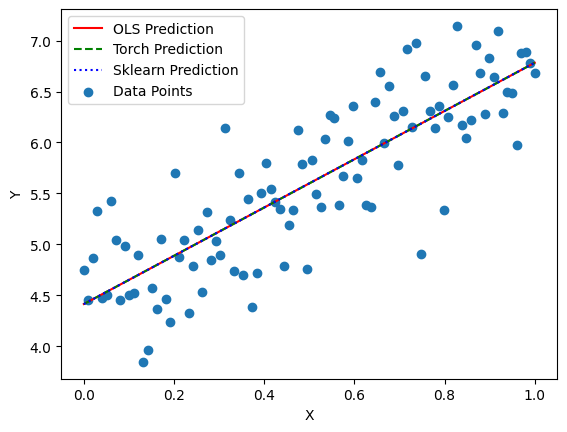

In [244]:
model_ols = RegressionOLS()
model_ols.fit(X.reshape(-1, 1), Y)
Y_pred_ols = model_ols.predict(X.reshape(-1, 1))
plt.plot(X, Y_pred_ols, color="red", label="OLS Prediction")

model_torch = RegressionTorch()
model_torch.fit(X.reshape(-1, 1), Y, epochs=2000, lr=0.05)
Y_pred_torch = model_torch.predict(X.reshape(-1, 1))
plt.plot(X, Y_pred_torch, color="green", linestyle="--", label="Torch Prediction")

model_sklearn = LinearRegression()
model_sklearn.fit(X.reshape(-1, 1), Y)
Y_pred_sklearn = model_sklearn.predict(X.reshape(-1, 1))
plt.plot(X, Y_pred_sklearn, color="blue", linestyle=":", label="Sklearn Prediction")

plt.scatter(X, Y, label="Data Points")

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

In [245]:
print("OLS Coefficients:", model_ols.coefficients[::-1])
print(
    "Torch Coefficients:",
    model_torch.model.weight.data.numpy(),
    model_torch.model.bias.data.numpy(),
)
print("Sklearn Coefficients:", model_sklearn.coef_, model_sklearn.intercept_)

OLS Coefficients: [2.36896634 4.41359357]
Torch Coefficients: [[2.3689392]] [4.4136095]
Sklearn Coefficients: [2.36896634] 4.413593572961313


In [246]:
path = kagglehub.dataset_download("prokshitha/home-value-insights")
print("Path to dataset files:", path)
file = "house_price_regression_dataset.csv"

Path to dataset files: /home/felix/.cache/kagglehub/datasets/prokshitha/home-value-insights/versions/1


In [247]:
df_1 = pd.read_csv(path + "/" + file)

In [248]:
df_1.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


In [249]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1000 non-null   int64  
 1   Num_Bedrooms          1000 non-null   int64  
 2   Num_Bathrooms         1000 non-null   int64  
 3   Year_Built            1000 non-null   int64  
 4   Lot_Size              1000 non-null   float64
 5   Garage_Size           1000 non-null   int64  
 6   Neighborhood_Quality  1000 non-null   int64  
 7   House_Price           1000 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB


In [250]:
df_1["House_Price"].describe()

count    1.000000e+03
mean     6.188610e+05
std      2.535681e+05
min      1.116269e+05
25%      4.016482e+05
50%      6.282673e+05
75%      8.271413e+05
max      1.108237e+06
Name: House_Price, dtype: float64

All ints/floats - we are good to go!

In [251]:
X_train, X_test, y_train, y_test = train_test_split(
    df_1.drop(columns=["House_Price"]),
    df_1["House_Price"],
    test_size=0.2,
    random_state=42,
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [252]:
model_ols = RegressionOLS()
model_ols.fit(X_train_scaled, y_train)

model_torch = RegressionTorch()
model_torch.fit(X_train_scaled, y_train.values, epochs=1000, lr=0.01)

model_sklearn = LinearRegression()
model_sklearn.fit(X_train_scaled, y_train)


preds = {}

for model, name in zip(
    [model_ols, model_torch, model_sklearn], ["OLS", "Torch", "Sklearn"]
):
    if name == "OLS":
        y_pred = model.predict(X_test_scaled)
    elif name == "Torch":
        y_pred = model.predict(X_test_scaled).flatten()
    else:
        y_pred = model.predict(X_test_scaled)

    preds[name] = y_pred

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("+-" * 40)
    print(
        f"{name} Model - MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}, MAE: {mae:.2f}, Avg Percent Error: {np.mean(np.abs((y_test - y_pred) / y_test)) * 100:.2f}%"
    )

+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
OLS Model - MSE: 101434798.51, RMSE: 10071.48, R2: 1.00, MAE: 8174.58, Avg Percent Error: 1.66%
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Torch Model - MSE: 101435725.29, RMSE: 10071.53, R2: 1.00, MAE: 8174.64, Avg Percent Error: 1.66%
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Sklearn Model - MSE: 101434798.51, RMSE: 10071.48, R2: 1.00, MAE: 8174.58, Avg Percent Error: 1.66%


In [253]:
class LassoRegressionTorch(RegressionTorch):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha

    def train(self, X_tensor, y_tensor, optimizer, criterion, epochs):
        for _ in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            mse_loss = criterion(outputs, y_tensor)
            l1_penalty = self.alpha * torch.sum(torch.abs(self.model.weight))
            loss = mse_loss + l1_penalty
            loss.backward()
            optimizer.step()


class RidgeRegressionTorch(RegressionTorch):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.alpha = alpha

    def train(self, X_tensor, y_tensor, optimizer, criterion, epochs):
        for _ in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            mse_loss = criterion(outputs, y_tensor)
            l2_penalty = self.alpha * torch.sum(self.model.weight**2)
            loss = mse_loss + l2_penalty
            loss.backward()
            optimizer.step()

In [254]:
model_torch_lasso = LassoRegressionTorch(alpha=0.1)
model_torch_lasso.fit(X.reshape(-1, 1), Y, epochs=1000, lr=0.01)

model_torch_ridge = RidgeRegressionTorch(alpha=0.1)
model_torch_ridge.fit(X.reshape(-1, 1), Y, epochs=1000, lr=0.01)

model_torch = RegressionTorch()
model_torch.fit(X.reshape(-1, 1), Y, epochs=1000, lr=0.01)

In [255]:
print("Baseline Torch Model Coefficients:")
print(model_torch)

print("Lasso Torch Model Coefficients:")
print(model_torch_lasso)

print("Ridge Torch Model Coefficients:")
print(model_torch_ridge)

Baseline Torch Model Coefficients:
Coefficients: [[2.2170124]]
Intercept: [4.4950304]
Lasso Torch Model Coefficients:
Coefficients: [[2.0153594]]
Intercept: [4.5819707]
Ridge Torch Model Coefficients:
Coefficients: [[1.1801071]]
Intercept: [5.0003724]


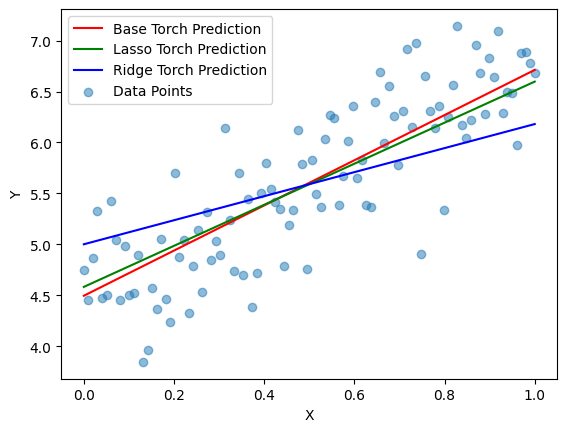

In [256]:
Y_pred_ols = model_torch.predict(X.reshape(-1, 1))
plt.plot(X, Y_pred_ols, color="red", label="Base Torch Prediction")

Y_pred_torch = model_torch_lasso.predict(X.reshape(-1, 1))
plt.plot(X, Y_pred_torch, color="green", label="Lasso Torch Prediction")

Y_pred_sklearn = model_torch_ridge.predict(X.reshape(-1, 1))
plt.plot(X, Y_pred_sklearn, color="blue", label="Ridge Torch Prediction")

plt.scatter(X, Y, label="Data Points", alpha=0.5)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

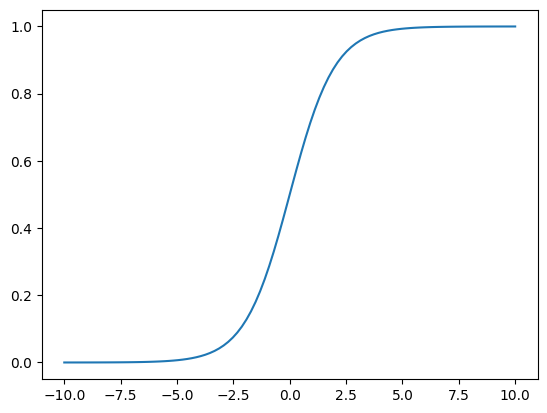

In [257]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


x = np.linspace(-10, 10, 100)
y = sigmoid(x)

plt.plot(x, y)

In [258]:
class LogisticRegressionTorch:
    def __init__(self):
        self.model = None

    def fit(self, X, y, epochs=1000, lr=0.01):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        n_samples, n_features = X_tensor.shape
        self.model = torch.nn.Linear(n_features, 1)

        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)

        self.train(X_tensor, y_tensor, optimizer, criterion, epochs)

    def train(self, X_tensor, y_tensor, optimizer, criterion, epochs):
        for _ in range(epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor).squeeze(1)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            logits = self.model(X_tensor)
            probabilities = torch.sigmoid(logits)
            return probabilities.numpy()
        return predictions.numpy()

In [259]:
path = kagglehub.dataset_download("yasserh/titanic-dataset")

df = pd.read_csv(path + "/Titanic-Dataset.csv")
df = df.drop(columns=["Name", "Ticket", "Cabin", "PassengerId"])
df = df.dropna()
df["Sex"] = pd.get_dummies(df["Sex"], drop_first=True).astype(int)
df["Embarked"] = LabelEncoder().fit_transform(df["Embarked"])

In [260]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [261]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["Survived"]), df["Survived"], test_size=0.2, random_state=42
)

In [262]:
logistic_model = LogisticRegressionTorch()
logistic_model.fit(X_train.values, y_train.values, epochs=30, lr=3e-4)
y_pred_probs = logistic_model.predict(X_test.values)
y_pred = (y_pred_probs >= 0.5).astype(int)

print(classification_report(y_test, y_pred, target_names=["died", "survived"]))

              precision    recall  f1-score   support

        died       0.72      0.68      0.70        80
    survived       0.62      0.67      0.64        63

    accuracy                           0.67       143
   macro avg       0.67      0.67      0.67       143
weighted avg       0.67      0.67      0.67       143



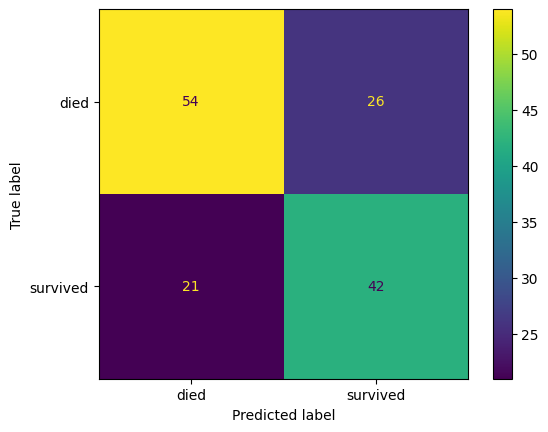

In [263]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["died", "survived"]).plot()

In [264]:
log_sk = LogisticRegression(max_iter=1000)
log_sk.fit(X_train, y_train)
y_pred_sk = log_sk.predict(X_test)
print(classification_report(y_test, y_pred_sk, target_names=['died', 'survived']))

              precision    recall  f1-score   support

        died       0.77      0.91      0.83        80
    survived       0.85      0.65      0.74        63

    accuracy                           0.80       143
   macro avg       0.81      0.78      0.79       143
weighted avg       0.81      0.80      0.79       143



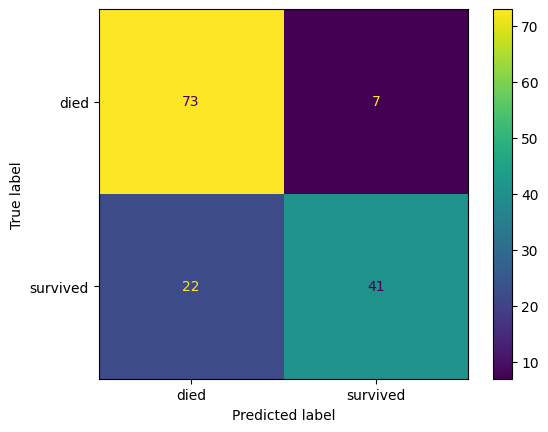

In [265]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_sk), display_labels=['died', 'survived']).plot()